In [1]:
import argparse
import requests
import random
import pickle
import torch
import json
import glob
import sys
import io

import PIL.Image

import numpy as np

In [2]:
sys.path.append('EDSR-PyTorch/src/')

In [3]:
import utility
import model

In [4]:
%matplotlib inline

In [5]:
device = 'cpu'
#device = 'cuda'

The following args datastructure was captured from a run of main.py with the following arguments:  
`$ python main.py --model EDSR --scale 2 --patch_size 96 --save edsr_baseline_x2 --reset`

In [6]:
json_args = '{"debug": false, "template": ".", "n_threads": 6, "cpu": false, "n_GPUs": 1, "seed": 1, "dir_data": "../../../dataset", "dir_demo": "../test", "data_train": ["DIV2K"], "data_test": ["DIV2K"], "data_range": "1-800/801-810", "ext": "sep", "scale": [2], "patch_size": 96, "rgb_range": 255, "n_colors": 3, "chop": false, "no_augment": false, "model": "EDSR", "act": "relu", "pre_train": "download", "extend": ".", "n_resblocks": 16, "n_feats": 64, "res_scale": 1, "shift_mean": true, "dilation": false, "precision": "single", "G0": 64, "RDNkSize": 3, "RDNconfig": "B", "n_resgroups": 10, "reduction": 16, "reset": true, "test_every": 1000, "epochs": 300, "batch_size": 16, "split_batch": 1, "self_ensemble": false, "test_only": false, "gan_k": 1, "lr": 0.0001, "decay": "200", "gamma": 0.5, "optimizer": "ADAM", "momentum": 0.9, "betas": [0.9, 0.999], "epsilon": 1e-08, "weight_decay": 0, "gclip": 0, "loss": "1*L1", "skip_threshold": 100000000.0, "save": "edsr_baseline_x2", "load": "", "resume": 0, "save_models": false, "print_every": 100, "save_results": false, "save_gt": false}'

In [7]:
args = argparse.Namespace()
args.__dict__ = json.loads(json_args)
args

Namespace(G0=64, RDNconfig='B', RDNkSize=3, act='relu', batch_size=16, betas=[0.9, 0.999], chop=False, cpu=False, data_range='1-800/801-810', data_test=['DIV2K'], data_train=['DIV2K'], debug=False, decay='200', dilation=False, dir_data='../../../dataset', dir_demo='../test', epochs=300, epsilon=1e-08, ext='sep', extend='.', gamma=0.5, gan_k=1, gclip=0, load='', loss='1*L1', lr=0.0001, model='EDSR', momentum=0.9, n_GPUs=1, n_colors=3, n_feats=64, n_resblocks=16, n_resgroups=10, n_threads=6, no_augment=False, optimizer='ADAM', patch_size=96, pre_train='download', precision='single', print_every=100, reduction=16, res_scale=1, reset=True, resume=0, rgb_range=255, save='edsr_baseline_x2', save_gt=False, save_models=False, save_results=False, scale=[2], seed=1, self_ensemble=False, shift_mean=True, skip_threshold=100000000.0, split_batch=1, template='.', test_every=1000, test_only=False, weight_decay=0)

Add the following argument to download pretrained weights:

In [8]:
args.pre_train = 'download'
args.cpu = device == 'cpu'
#args.scale = [4]

In [9]:
checkpoint = utility.checkpoint(args)

In [10]:
net = model.Model(args, checkpoint)
_ = net.eval()

Making model...
Download the model


In [11]:
image_url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/2012_Suedchinesischer_Tiger.JPG/1280px-2012_Suedchinesischer_Tiger.JPG'

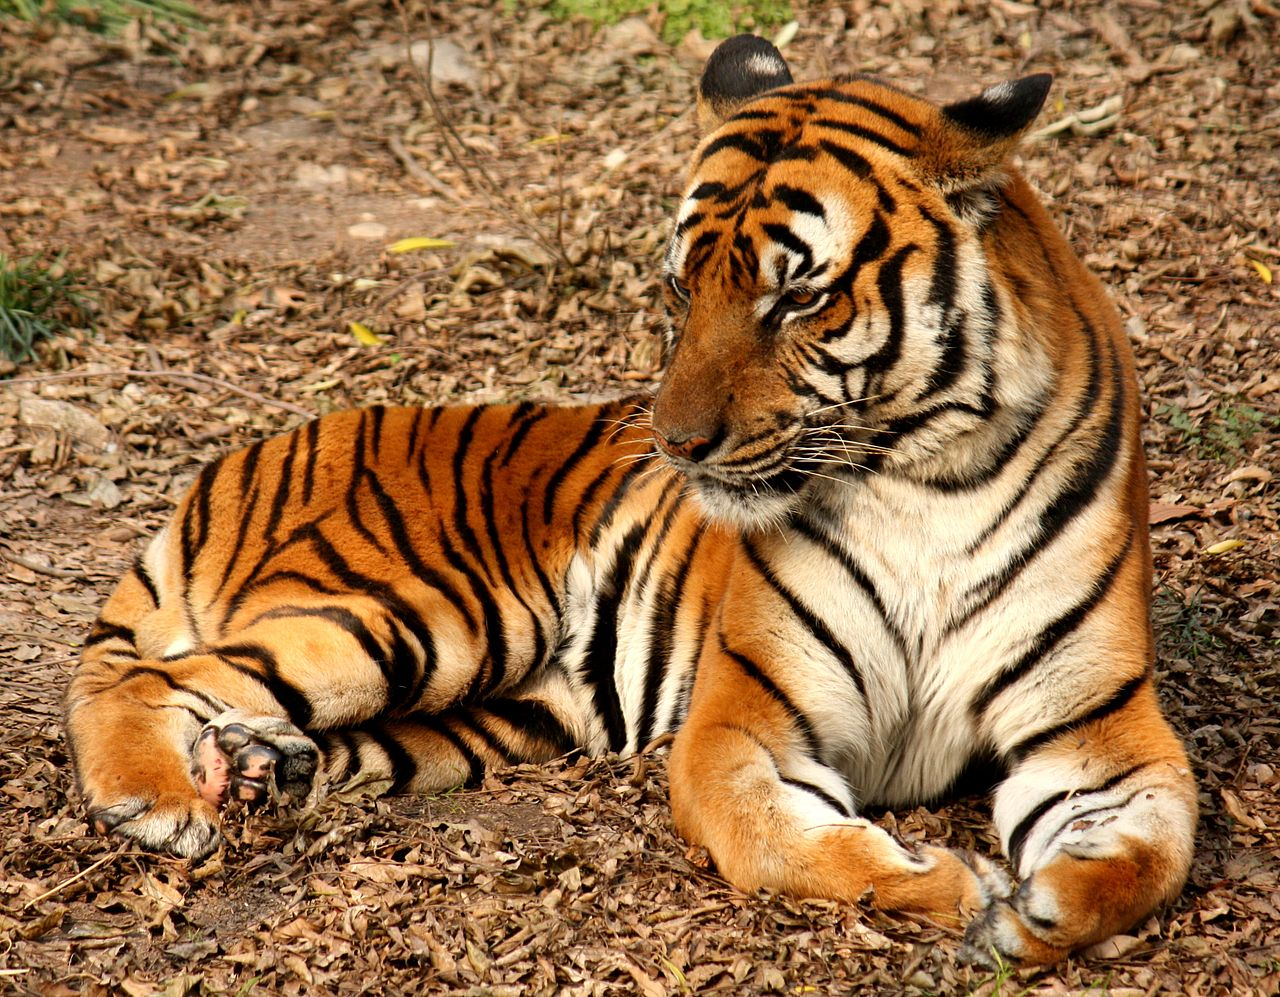

In [12]:
im = PIL.Image.open(io.BytesIO(requests.get(image_url).content))
im

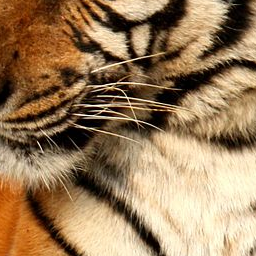

In [13]:
csize = 256

l = random.random() * (im.size[0] - csize)
b = random.random() * (im.size[1] - csize)

im0 = im.crop((l, b, l + csize, b + csize))
im0

In [14]:
a1 = np.expand_dims(np.array(im0, dtype=np.float32), 0).transpose(0, 3, 1, 2)
a1.shape

(1, 3, 256, 256)

In [15]:
np.percentile(a1, range(0, 101, 10))

array([  0.,  12.,  37.,  65.,  94., 123., 153., 181., 206., 233., 255.])

In [16]:
x = torch.from_numpy(a1).to(device)

In [17]:
%time y0 = net(x, idx_scale=0).to('cpu').detach().numpy()
y0.shape

CPU times: user 50.9 s, sys: 4.4 s, total: 55.3 s
Wall time: 7.18 s


(1, 3, 512, 512)

In [18]:
y1 = y0[0].transpose(1, 2, 0)

In [19]:
np.percentile(y1.astype(np.int16), range(0, 101, 10))

array([-47.,  10.,  35.,  63.,  93., 122., 153., 182., 206., 234., 301.])

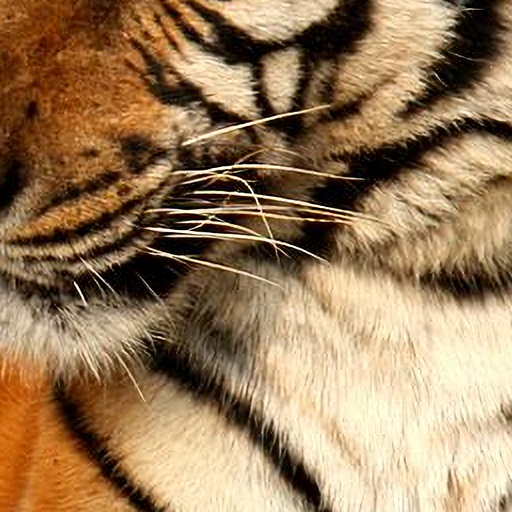

In [20]:
PIL.Image.fromarray(y1.clip(0, 255).astype(np.uint8))

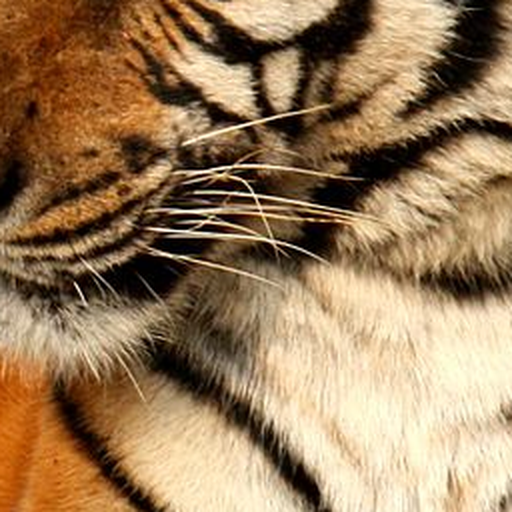

In [21]:
im0.resize((2 * im0.size[0], 2 * im0.size[1]), resample=PIL.Image.LANCZOS)